In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *  

C:\Users\odhra\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data() 

train_im = train_images.reshape(60000,784)

print(train_im.shape)

td = zeros((120000,784))

for x in range(0,60000):
    td[2*x]=train_im[x]
    

timed_data = td

print(timed_data.shape)

(60000, 784)
(120000, 784)


In [128]:
start_scope()

taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''


ta = TimedArray((timed_data)*Hz, dt=5*ms)





Poisson_layer = PoissonGroup(784,rates = 'ta(t, i)')
layer_V1 = NeuronGroup(784, eqs_neurons, threshold='v>vt', reset='v = vr', refractory=2*ms, method='linear')
layer_V2 = NeuronGroup(784, eqs_neurons, threshold='v>vt', reset='v = vr', refractory=2*ms, method='linear')






#poisson to layer 1
P_to_V1 = Synapses(Poisson_layer, layer_V1,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
P_to_V1.connect()
P_to_V1.w = 'rand() * gmax'




#layer 1 to layer 2
V1_to_V2 = Synapses(layer_V1, layer_V2,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
V1_to_V2.connect(condition='i!=j', p=0.5)
V1_to_V2.w = 'gmax'



spikemon_P = SpikeMonitor(Poisson_layer)
spikemon_V1 = SpikeMonitor(layer_V1)
spikemon_V2 = SpikeMonitor(layer_V2)



run(400*ms)

trains = spikemon_V2.spike_trains()

trains_pre_array = np.array(list(trains.values()))*1000

spikematrix = zeros((784,400)) # check you have this bit the right way around! 


for x in range(0,784):
    results = list(map(int, trains_pre_array[x]))
    spikematrix[x,results] = 1

print(spikematrix.shape)





(784, 400)


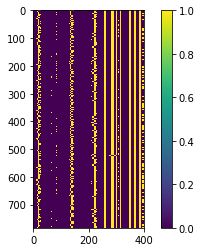

In [129]:
plt.figure()
plt.imshow(spikematrix)
plt.colorbar()
plt.grid(False)